In [1]:
# Cell to allow importation of script in parent folder
import sys
import os

from ray.rllib.utils import sigmoid

current_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "../")))

# EASE

...

In [2]:
from ease import EASE
from data_formatting import DataFormatting
import pandas as pd

%load_ext autoreload
%autoreload 2

In [3]:
data = DataFormatting('../data/train.csv')
X, maps = data.create_matrix_csr()
test_df = pd.read_csv("../data/test.csv")

In [4]:
ease = EASE(X=X, maps=maps)

In [5]:
ease.fit()

Computing the Gram-Matrix... [1/4]
Adding lambda to the diagonal of Gram-Matrix... [2/4]
Computing the inverse of Gram-Matrix... [3/4]
Compute the weight matrix... [4/4]

Training completed in 0:01:35.662567


In [6]:
ease.predict()

Starting to predict score of all (user,book) pairs...
Map score into a 1 to 5 score range...

Prediction completed in 0:00:05.728480


In [7]:
ease.retrieve_pred(df=test_df)

In [8]:
ease.save_pred()

In [9]:
ease.score.max(), ease.score.min(), ease.score.mean()

(1.0046707814742748, -0.3469435765264077, 6.441760532757954e-05)

In [10]:
ease.rating.max(), ease.rating.min(), ease.rating.mean()

(5.0, 1.0, 2.026943793775749)

In [11]:
ease.pred.max(), ease.pred.min(), ease.pred.mean()

(2.933129690379622, 1.6268840265791316, 2.0270939901101053)

In [12]:
import numpy as np

look_results = pd.read_csv('../data/train.csv')
user_to_index = maps['user_to_index']
book_to_index = maps['item_to_index']
look_results['pred'] = look_results.apply(
    lambda row: ease.rating[user_to_index[row['user_id']], book_to_index[row['book_id']]], axis=1
)
look_results['mse'] = look_results.apply(lambda row: np.sqrt((row['rating'] - row['pred'])**2), axis=1)
look_results['mse'].mean()

0.8321925348584884

In [13]:
#look_results[look_results['mse'] <= look_results['mse'].mean()]

## Distribution of rating in the training dataset

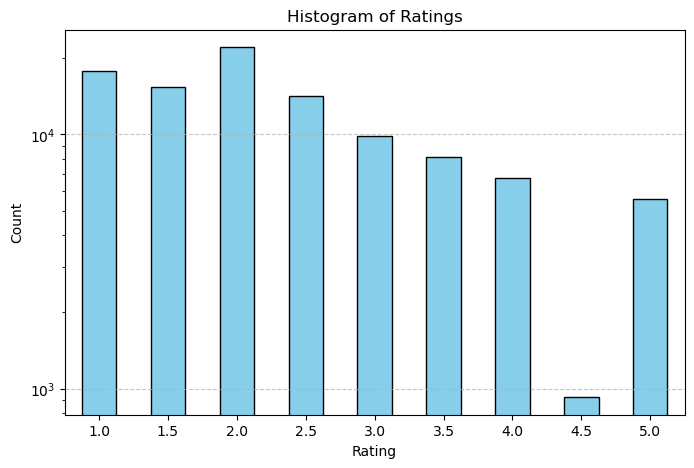

In [19]:
import matplotlib.pyplot as plt 
from collections import Counter

train_df = pd.read_csv('../data/train.csv')

# Convert to a DataFrame
rating_counts_df = pd.DataFrame.from_dict(Counter(train_df['rating']), orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(8, 5))
rating_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Ratings')
plt.xticks(ticks=range(len(rating_counts_df.index)), labels=rating_counts_df.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Distribution of rating in the rating matrix

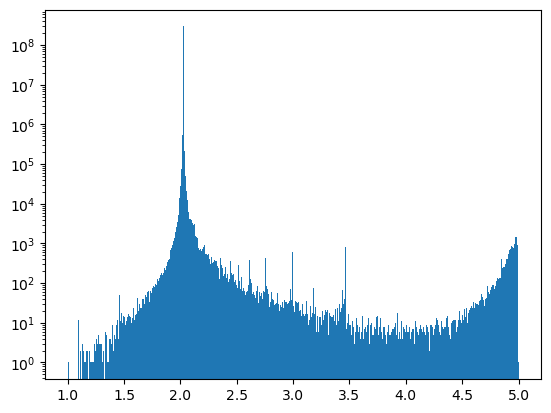

In [16]:
plt.hist(ease.rating.flatten(), bins=500)
plt.yscale('log')

## Distribution of rating in prediction file

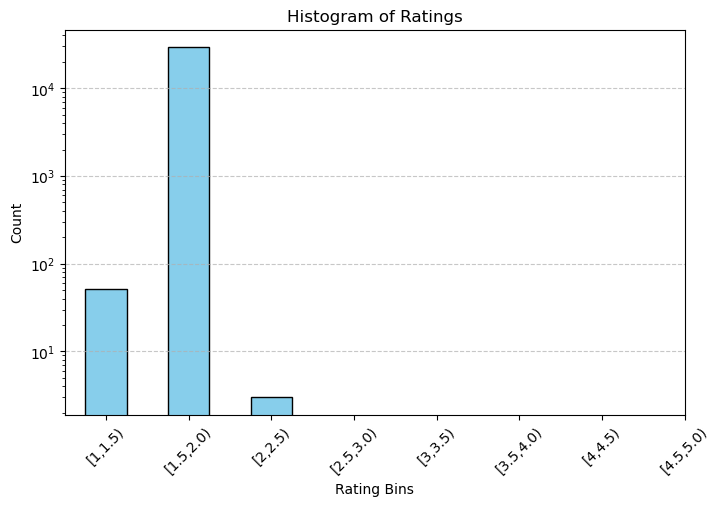

In [18]:
# Define bins and labels
bins = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = bins[:-1]  # Use bin edges except the last one for labeling

# Bin the predictions
binned_preds = pd.cut(ease.pred, bins=bins, labels=labels, right=False)  # `right=False` ensures intervals like [1, 1.5)

# Count the occurrences in each bin
binned_counts = Counter(binned_preds)

# Convert to a DataFrame for plotting
binned_counts_df = pd.DataFrame.from_dict(binned_counts, orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(8, 5))
binned_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating Bins')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Ratings')
plt.xticks(ticks=range(len(bins) - 1), labels=[f"[{b},{b+0.5})" for b in bins[:-1]], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

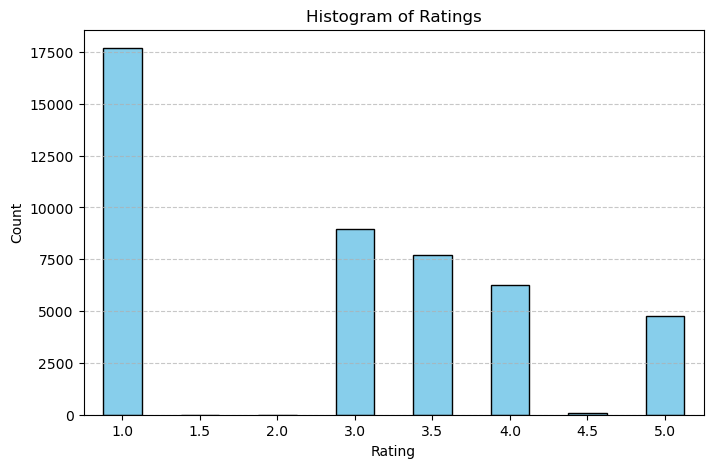

In [21]:
rating_counts = Counter(look_results[look_results['mse'] >= look_results['mse'].mean()]['rating'])

# Convert to a DataFrame
rating_counts_df = pd.DataFrame.from_dict(Counter(rating_counts), orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(8, 5))
rating_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings')
plt.xticks(ticks=range(len(rating_counts_df.index)), labels=rating_counts_df.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

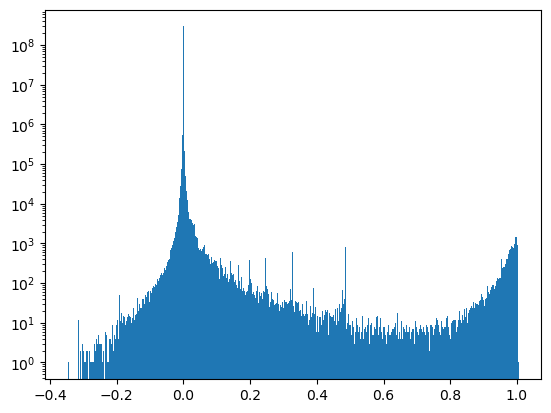

In [20]:
plt.hist(ease.score.flatten(), bins=500)
plt.yscale('log')
#plt.xlim(-0.5, 1)

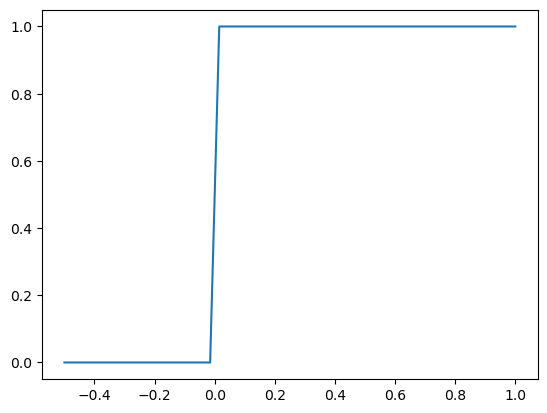

In [52]:
sigmoid = lambda x: 1 / (1 + np.exp(-1200 * x))

plt.plot(np.linspace(-0.5, 1, num=100), [sigmoid(x) for x in np.linspace(-0.5, 1, num=100)])

In [53]:
sig_score = sigmoid(ease.score)

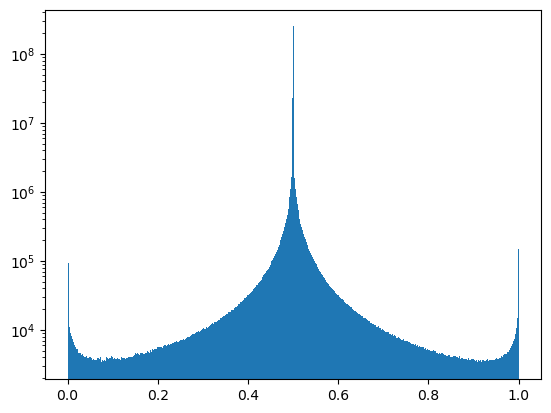

In [54]:
plt.hist(sig_score.flatten(), bins=500)
plt.yscale('log')

In [56]:
min_score, max_score = ease.score.min(), ease.score.max()

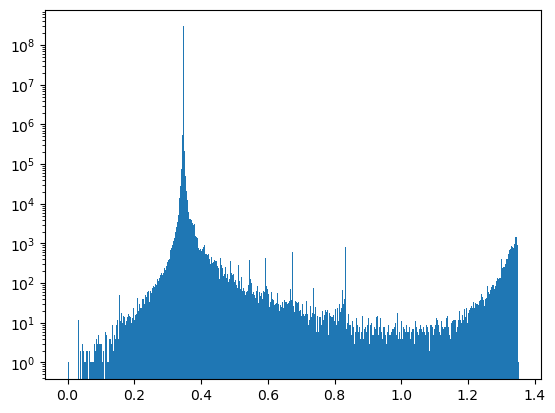

In [58]:
root_score = ease.score - min_score
plt.hist(root_score.flatten(), bins=500)
plt.yscale('log')

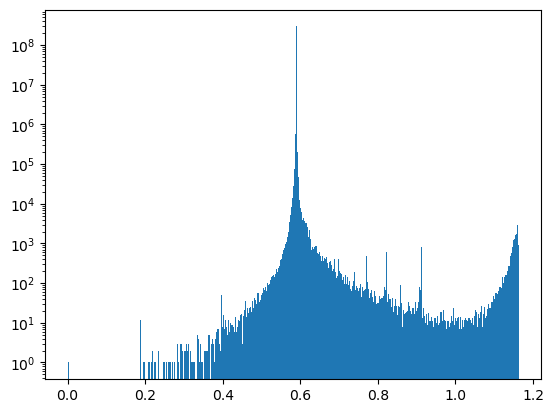

In [59]:
root_score = np.sqrt(root_score)
plt.hist(root_score.flatten(), bins=500)
plt.yscale('log')